In [1]:
from utils import VAEReg, BrainGraphDataset
import torch
import os
from torch.utils.data import random_split
import torch.optim as optim
from tqdm import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

# set the random seed for reproducibility
torch.manual_seed(0)

# define the hyperparameters
input_dim = 100 * 100  # size of the graph adjacency matrix
hidden_dim = 256
latent_dim = 64
lr = 1e-3
batch_size = 128
num_epochs = 500

annotations = 'annotations.csv'
dataroot = 'fc_matrices/hcp_100_ica/'
cwd = os.getcwd() + '/'

hcp_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + dataroot + annotations,
                            transform=None, extra_data=None, setting='class_weighted_graph')

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_dataset = BrainGraphDataset(img_dir=cwd + dataroot,
                            annotations_file=cwd + annotations,
                            transform=None, extra_data=None, setting='class_weighted_graph')

from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

# Assuming hcp_dataset and psilo_dataset are the datasets created from BrainGraphDataset

# Calculate the number of samples in each dataset
num_hcp_samples = len(hcp_dataset)
num_psilo_samples = len(psilo_dataset)

# Calculate the class weights proportionally
total_samples = num_hcp_samples + num_psilo_samples
hcp_weight = num_psilo_samples / total_samples
psilo_weight = num_hcp_samples / total_samples

hcp_dataset.class_weight = hcp_weight
psilo_dataset.class_weight = psilo_weight

train_prop = 0.8

# split the hcp dataset into training and validation sets
hcp_train_size = int(train_prop * num_hcp_samples)
hcp_val_size = num_hcp_samples - hcp_train_size
hcp_train_dataset, hcp_val_dataset = random_split(hcp_dataset, [hcp_train_size, hcp_val_size])

# split the psilo dataset into training and validation sets
psilo_train_size = int(train_prop * num_psilo_samples)
psilo_val_size = num_psilo_samples - psilo_train_size
psilo_train_dataset, psilo_val_dataset = random_split(psilo_dataset, [psilo_train_size, psilo_val_size])

# Create the combined dataset and targets
combined_train_dataset = torch.utils.data.ConcatDataset([hcp_train_dataset, psilo_train_dataset])
combined_val_dataset = torch.utils.data.ConcatDataset([hcp_val_dataset, psilo_val_dataset])

# Create the mixed class loader
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(combined_train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)

train_set = combined_train_dataset
val_set = combined_val_dataset

dropout = 0.05
l2_strength = 0.01

best_val_loss = float('inf')  # set to infinity to start
best_model_state = None
train_losses = []
val_losses = []
model = VAEReg(input_dim, hidden_dim, latent_dim, dropout=dropout, l2_strength=l2_strength, device=device).to(device)  # move model to device
optimizer = optim.Adam(model.parameters(), lr=lr)
    
# for epoch in tqdm(range(num_epochs)):
#     train_loss = 0.0
#     val_loss = 0.0

#     # training
#     model.train()
#     for batch_idx, ((graph, class_weights), _) in enumerate(train_loader):
#         graph = graph.to(device)
#         class_weights = class_weights.to(device).float()
#         optimizer.zero_grad()

#         recon, mu, logvar, _ = model(graph.view(-1, input_dim))
#         loss = model.loss(recon, graph.view(-1, input_dim), mu, logvar, n_components=3, class_weights=class_weights)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()

#     # validation
#     model.eval()
#     with torch.no_grad():
#         for batch_idx, ((graph, class_weights), _) in enumerate(val_loader):
#             graph = graph.to(device)
#             class_weights = class_weights.to(device).float()
#             recon, mu, logvar, _ = model(graph.view(-1, input_dim))
#             loss = model.loss(recon, graph.view(-1, input_dim), mu, logvar, n_components=3, class_weights=class_weights)

#             val_loss += loss.item()
            
#     train_losses.append(train_loss/len(train_set))
#     val_losses.append(val_loss/len(val_set))
    
#     # save the model if the validation loss is at its minimum
#     if val_losses[-1] < best_val_loss:
#         best_val_loss = val_losses[-1]
#         best_model_state = model.state_dict().copy()

#     # print the losses
#     with open('dropout_train.txt', 'a') as f:
#         f.write(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')
#         print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}\n')

# # save the best model for this configuration
# torch.save(best_model_state, f'vgae_weights/mixed_class_{dropout}_{l2_strength}_best.pt')

# # make loss curves
# loss_curves = {}
# loss_curves['train_curve'] = train_losses
# loss_curves['val_curve'] = val_losses

# import json
# # save the loss curves to a file
# with open("loss_curve_mixed_class_reg.json", "w") as f:
#     json.dump(loss_curves, f)

cpu


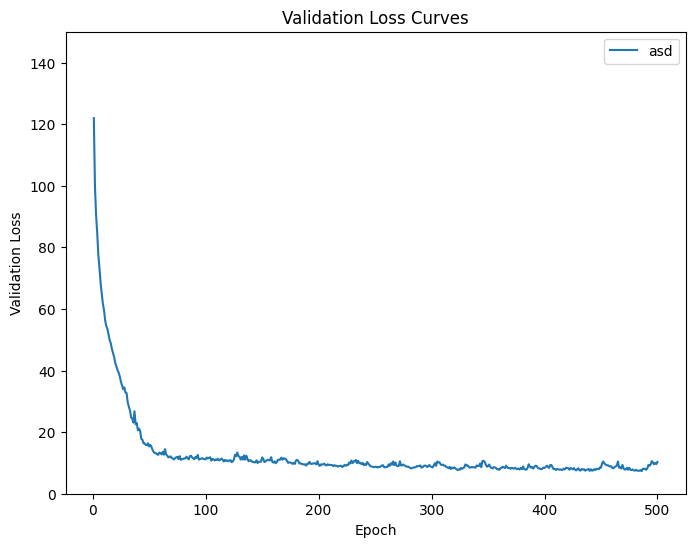

In [5]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curve_mixed_class_reg.json", "r") as f:
    loss_curves = json.load(f)

val_losses = loss_curves['val_curve']
# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))

epochs = range(1, len(val_losses) + 1)
plt.plot(epochs, val_losses, label=f"asd")

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curves")
plt.legend()
plt.ylim((0, 150))

# show the plot
plt.show()


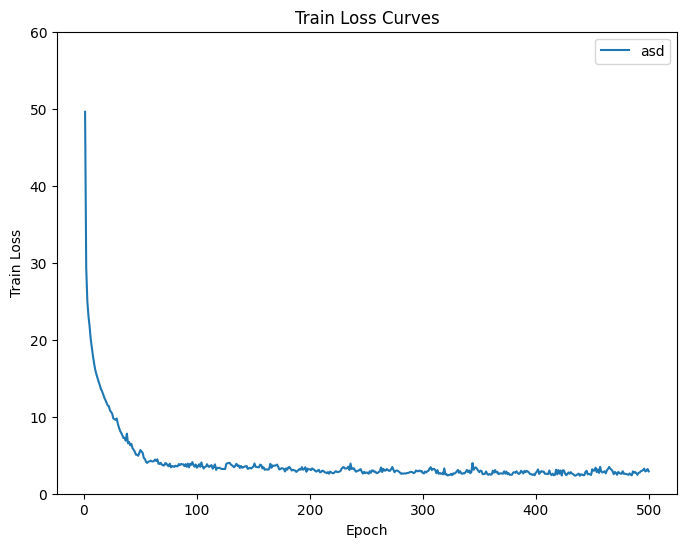

In [7]:
import json
import matplotlib.pyplot as plt

# load in the loss curves from file
with open("loss_curve_mixed_class_reg.json", "r") as f:
    loss_curves = json.load(f)

train_losses = loss_curves['train_curve']
# plot the validation loss curves for each number of GMM components
plt.figure(figsize=(8, 6))

epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='asd')

# add labels and legend
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Train Loss Curves")
plt.legend()
plt.ylim((0, 60))

# show the plot
plt.show()

In [9]:
# load in the models and get the validation loss for each
models = []
val_losses = []
l2_strength = 0.01
dropout = 0.05

# instantiate the model
model = VAEReg(input_dim, hidden_dim, latent_dim, device=device).to(device)

# load the weights
model.load_state_dict(torch.load(f'vae_weights/mixed_class_{dropout}_{l2_strength}_best.pt', map_location=device))

# set the model to evaluation mode
model.eval()

# calculate the validation loss
val_loss = 0.0
with torch.no_grad():
    for batch_idx, ((graph, class_weights), _) in enumerate(val_loader):
        graph = graph.to(device)
        class_weights = class_weights.to(device).float()
        recon, mu, logvar, _ = model(graph.view(-1, input_dim))
        loss = model.loss(recon, graph.view(-1, input_dim), mu, logvar, n_components=3, class_weights=class_weights)

        val_loss += loss.item()
val_loss /= len(val_set)

# print the validation loss for each model
print(f'Validation Loss = {val_loss:.4f}')

Validation Loss = 10.1600


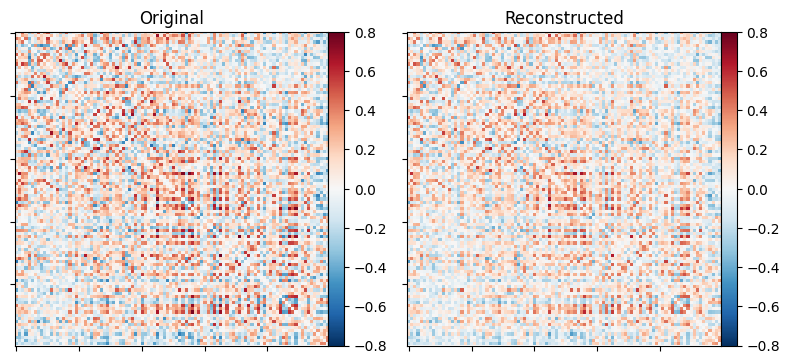

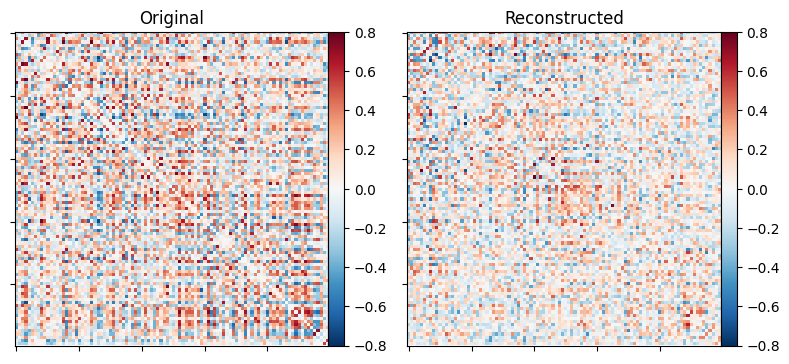

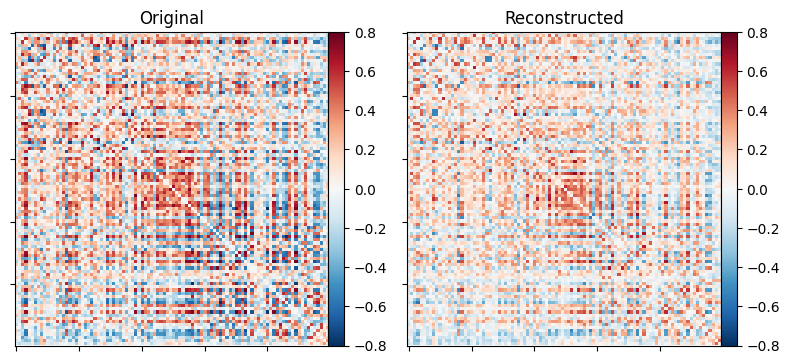

In [10]:
import matplotlib.pyplot as plt
from nilearn import plotting

psilo_loader = DataLoader(psilo_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
hcp_loader = DataLoader(hcp_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)


# select a batch from the validation data loader
(graph, class_weight), _ = next(iter(psilo_loader))

graph = graph.to(device)
# pass the batch through the trained model to obtain the reconstructed output
recon, _, _, _ = model(graph.view(-1, input_dim))

# reshape the output to a 100x100 matrix (assuming the input_dim is 100x100)
recon = recon.view(-1, 100, 100)

for i in range(3):
    # plot the original and reconstructed matrices for the first sample in the batch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    plotting.plot_matrix(graph[i].cpu(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax1)
    ax1.set_title('Original')
    plotting.plot_matrix(recon[i].cpu().detach(), colorbar=True, vmax=0.8, vmin=-0.8, axes=ax2)
    ax2.set_title('Reconstructed')
    plt.show()

In [4]:
hidden_dim = 256
latent_dim = 64
input_dim = 100 * 100

model = VAEReg(input_dim, hidden_dim, latent_dim, device=device).to(device)

model.load_state_dict(torch.load('vgae_weights/mixed_class_0.05_0.01_best.pt', map_location=device))

psilo_zs = []
hcp_zs = []

with torch.no_grad():
    for batch_idx, ((graph, _), _) in enumerate(psilo_loader):
        graph = graph.to(device)
        _, _, _, z = model(graph.view(-1, input_dim))
        psilo_zs.append(z)
    
    for batch_idx, ((graph, _), _) in enumerate(hcp_loader):
        graph = graph.to(device)
        _, _, _, z = model(graph.view(-1, input_dim))
        hcp_zs.append(z)

psilo_zs = torch.cat(psilo_zs, dim=0)
hcp_zs = torch.cat(hcp_zs, dim=0)
        
# Concatenate the encoded representations and create labels
x = torch.cat((psilo_zs, hcp_zs), dim=0)
labels = torch.cat((torch.zeros(psilo_zs.shape[0]), torch.ones(hcp_zs.shape[0])), dim=0)

from sklearn.manifold import TSNE

for per in [30, 40, 50]:
    # Use t-SNE to reduce the dimensionality of the encoded representations
    tsne = TSNE(n_components=2, perplexity=per, n_iter=1000)
    x_tsne = tsne.fit_transform(x.cpu())

    # Plot the t-SNE embeddings
    plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=labels, cmap='coolwarm')
    plt.colorbar()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'vgae_weights/mixed_class_0.05_0.01_best.pt'